In [1]:
from spellchecker import SpellChecker
from spacy.matcher.matcher import Matcher # NVB, NAJ, NPV
from spacy.symbols import nsubj, nsubjpass, dobj, conj, pobj, prep, amod, NOUN, VERB, ADJ, ADV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import nltk
import spacy
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

[nltk_data] Downloading package punkt to /Users/kyuliew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kyuliew/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kyuliew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



    Features to extract:
    AWL – Average Word Length
    ASL – Average Sentence Length
    NOW – Number of Words
    NVB – Number of Verbs
    NAJ – Number of Adjectives
    NPV – Number of Passive Voice Constructions
    NST – Number of Sentences
    CDV – Content Diversity = |V| / #tokens (ignore punctuation & stopwords)
    NTP – Number of Typos
    TPR – Typo Ratio


In [2]:
df = pd.read_excel("data/original/restaurant_reviews-v2-1.xlsx")

In [3]:
df.head()

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,Tikka Shack,Great food and great atmosphere! The chicken t...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tikka Shack,I had heard good things about Tikka Shak so I ...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tikka Shack,I was driving by tikka shack one day and decid...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tikka Shack,Tikka Shack had the most modern and up-to-date...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India Palace\nIndian\nRestaurant,Today is the third time I've come to India Pal...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Perform Sentence and Word tokenization to prepare for feature extraction

In [4]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+\'?\w+|\w+')
spell = SpellChecker()
parts_speech = spacy.load("en_core_web_sm")

In [5]:
df['tokenized_sents'] = df.apply(lambda row: sent_tokenize(row['Review']), axis=1)

In [6]:
df['tokenized_words'] = df.apply(lambda row: tokenizer.tokenize(row['Review']), axis=1)

In [7]:
"""
  Performs tokenization and lowercase on all sentences in the review. 
  Performs part of speech tagging and lemmatization and appends the tagged sentence to a list for extraction.
  Counts the total word count and total word length as well as appending any alphabetic words to a list for spell checking.
  Afterwards, count number of verbs, adjectives, passive voice contructions, and lemmas (ignoring punctuation and stop words).
  Then computes the average word length, average sentence length, total sentence count, content diversity, total typos, and typo ratio.
  Returns as a series object to be applied into the dataframe.
"""
def tokenize_sentence_words(row):

  total_word_length = 0 
  total_word_count = 0
  total_verbs = 0
  total_adj = 0
  total_passive = 0

  words_sc = []  
  tokens = [] 
  tagged_sentences = []

  for sentence in row:
    words = tokenizer.tokenize(sentence.lower())
    total_word_count += len(words)
    tagged_sentences.append(parts_speech(sentence))

    for word in words:
      total_word_length += len(word)

      if word.isalpha():
        words_sc.append(word)  

  for tagged_sent in tagged_sentences:
    for token in tagged_sent:
        if token.is_alpha and not token.is_stop and not token.is_punct:
          tokens.append(token.lemma_)
        if token.pos_ == "VERB":
          total_verbs += 1
        if token.pos_ == "ADJ":
          total_adj += 1
        if token.dep_ in ("nsubjpass", "auxpass", "csubjpass"):
          total_passive += 1


  avg_word_length = round(total_word_length / total_word_count, 2)

  avg_sentence_length = round(total_word_count / len(row), 2)

  total_sentence_count = len(row) 

  unique_vocab = len(set(tokens))

  content_diversity = round(unique_vocab / len(tokens), 2)

  spell_check = spell.unknown(words_sc)

  total_typos = len(spell_check)

  typo_ratio = round(total_typos / total_word_count, 2)

  # print(f'Review: {row}')
  # print(f'Word Count: {total_word_count}')
  # print(f'Total Word Length: {total_word_length}')
  # print(f'Avg Word Length: {avg_word_length:.2f}')

  # print(f'Sentence Count: {total_sentence_count}')
  # print(f'Avg Sentence Length: {avg_sentence_length}')  

  # print(f'Content Diversity: {content_diversity}')
  # print(f'Total Verbs: {total_verbs}')
  # print(f'Total Adjectives: {total_adj}')
  # print(f'Total Passive Voice Construction: {total_passive}')

  # print(f'Number of typos: {num_typos}')
  # print(f'Typo ratio: {typo_ratio}')

  return pd.Series([avg_word_length, avg_sentence_length, total_word_count, total_verbs, total_adj, total_passive, total_sentence_count, content_diversity, total_typos, typo_ratio], index=['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'CDV', 'NTP', 'TPR'])

# Perform feature extraction

In [8]:
df[['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'CDV', 'NTP', 'TPR']] = df['tokenized_sents'].apply(lambda row: tokenize_sentence_words(row))

# Clean-up and checking results

In [9]:
df = df.drop(["Review","Restaurant", "positive=1/negative=0", "tokenized_sents", "tokenized_words"], axis=1)

In [10]:
df[['NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'NTP']] = df[['NOW', 'NVB', 'NAJ', 'NPV',  'NST', 'NTP']].astype(int)

In [11]:
df

,Real=1/Fake=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,0,4.67,16.60,83,12,6,0,5,0.89,5,0.06
1,0,4.07,18.17,109,15,8,2,6,0.95,4,0.04
2,0,3.61,16.00,112,15,4,4,7,0.86,1,0.01
3,0,4.39,15.25,61,9,7,0,4,0.92,1,0.02
4,0,4.50,14.80,74,10,9,0,5,0.90,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
255,0,4.12,10.40,52,4,4,0,5,0.94,2,0.04
256,1,4.30,18.00,90,9,7,2,5,0.97,0,0.00
257,0,4.52,11.83,71,7,9,0,6,0.85,2,0.03
258,1,4.67,18.00,54,5,6,0,3,0.90,4,0.07


# Correlation Matrix

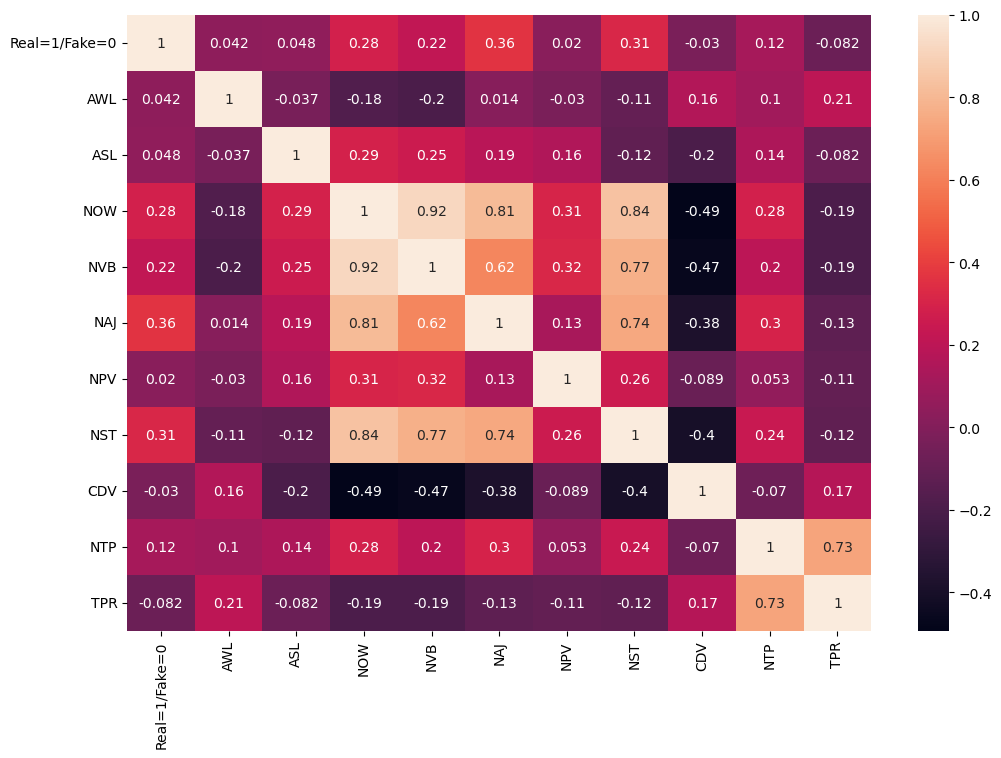

In [12]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="rocket", annot=True)
plt.show()

In [13]:
"""
  Helper function to save datasets to csv files.
"""
def save_csv(df, output_dir, filename):

  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  full_path = output_dir + filename

  df.to_csv(full_path, index=False)
  print(f"{filename} saved.")

In [14]:
save_csv(df, 'data/preprocessed/', 'reviewFeatures.csv')

reviewFeatures.csv saved.
